# <center>Trabajo Práctico 1: Reservas de Hotel</center>

## <center>Organización de Datos</center>
#### <center>Cátedra Ing. Rodriguez, Juan Manuel </center>

Grupo 32 - Kung Fu Pandas

Integrantes:
* Daniel Agustin Marianetti - Padrón: 106256
* Franco Rodriguez - Padrón: 102815
* Ezequiel Lazarte - Padrón: 108063

Importamos las librerias que vamos a utilizar

In [ ]:
#Gral.
import pandas as pd
import numpy as np
import joblib

#Plots
import matplotlib.pyplot as plt
import seaborn as sns

#Modelado
import sklearn as sk
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC as SVClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
import xgboost as xgb

#Ensamblado
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

#Metricas
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, classification_report

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train_procesado = pd.read_csv('/content/drive/MyDrive/datasetsTP/hotels_train_procesado.csv')
df_trabajo = df_train_procesado.copy()

df_test_procesado = pd.read_csv('/content/drive/MyDrive/datasetsTP/hotels_test_procesado.csv')
df_trabajo_test = df_test_procesado.copy()

resultados_modelos = {}

## Preprocesamiento

In [ ]:
df_trabajo.drop(['meal', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'adults'], inplace=True, axis=1)
df_trabajo_test.drop(['meal', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'adults'], inplace=True, axis=1)

In [ ]:
var_categoricas = set(['hotel', 'arrival_date_month',
                         'arrival_date_day_of_month', 'country',
                         'reserved_room_type', 'assigned_room_type',
                         'is_repeated_guest', 'deposit_type', 'agent',
                         'customer_type', 'distribution_channel', 'market_segment'])

label_encoder = preprocessing.LabelEncoder()

for col in df_trabajo.columns:
  if col in var_categoricas:
    df_trabajo[col] = label_encoder.fit_transform(df_trabajo[col])

for col in df_trabajo_test.columns:
  if col in var_categoricas:
    df_trabajo_test[col] = label_encoder.fit_transform(df_trabajo_test[col])

Aplicamos LabelEncoder a todas las variables que no sean numericas para poder utilizarlas

In [ ]:
df_trabajo.drop(['id'], axis='columns', inplace=True)

# Obtengo los ids para agregarlos después y aprovecho a sacar la variable que no esta en el ds de train
ids_submit = df_trabajo_test['id']
df_trabajo_test.drop(['id', 'reservation_status_date'], axis='columns', inplace=True)

## Definición Set de Entrenamiento y Set de Test

In [ ]:
df_trabajo_x = df_trabajo.drop('is_canceled', axis='columns')

df_trabajo_y = df_trabajo['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=1010) #semilla

# Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 42777
# Datos Prueba: 18334
% Positivos Entrenamiento: 50.025
% Positivos Prueba: 50.442


Generamos un set de train y test normalizado para entrenar todos los modelos, la explicación está en la sección de SVM Model pero debemos definirlos ahora porque entrenaremos todos nuestros modelos con los datos normalizados para luego, al ensamblar, no encontrarnos con errores debido a usar diferentes formatos de los datos de entrenamiento

In [ ]:
#Normalizo los datos de train y entreno el modelo, transformo los datos de test
stand_scaler = preprocessing.StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm = stand_scaler.transform(x_test)

df_trabajo_test_norm = stand_scaler.transform(df_trabajo_test)

##Funciones ùtiles

A continuación la función brindada por la cátedra para la muestra de la matriz de confusión para datos de train y test.

In [ ]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))

  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

Función para generar la predicción contra el conjunto brindado y crear un df que puede ser subido a la competencia de Kaggle

In [ ]:
def generar_df_submit(modelo):

  submit_pred = modelo.predict(df_trabajo_test)

  df_submit = pd.DataFrame(zip(ids_submit,submit_pred),columns=['id','is_canceled'])

  print("Verificamos que contenga las columnas requeridas y un total de 26535 filas")

  df_submit.info()

  print()

  return df_submit

Creamos otra función para generar la predicción contra el conjunto brindado pero normalizado y crear un df que puede ser subido a la competencia de Kaggle para las predicciones.

In [ ]:
def generar_df_submit_norm(modelo):

  submit_pred = modelo.predict(df_trabajo_test_norm)

  df_submit = pd.DataFrame(zip(ids_submit,submit_pred),columns=['id','is_canceled'])

  print("Verificamos que contenga las columnas requeridas y un total de 26535 filas")

  df_submit.info()

  print()

  return df_submit

## KNN model

Construimos un clasificador KNN optimizando sus hiperparámetros mediante k-fold Cross Validation

In [ ]:
params_grid={ 'n_neighbors':range(1,30), # Cantidad de vecinos con que se compara para defiinir el grupo de la observación
              'weights':['distance','uniform', None], # Define diferencias o no en el peso de cada vecino
              'algorithm':['ball_tree', 'kd_tree', 'brute'], # Algoritmo de comparación
              'metric':['euclidean','manhattan','chebyshev'] # Medida de distancia que define la cercanía
             }

knn=KNeighborsClassifier()
cant_folds = 15
cant_iteraciones = 15

cv_knn_model = RandomizedSearchCV(knn, params_grid, cv=cant_folds, scoring='f1', n_iter=cant_iteraciones, random_state=1010)

cv_knn_model.fit(x_train_norm, y_train)

RandomizedSearchCV(cv=15, estimator=KNeighborsClassifier(), n_iter=15,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'metric': ['euclidean', 'manhattan',
                                                   'chebyshev'],
                                        'n_neighbors': range(1, 30),
                                        'weights': ['distance', 'uniform',
                                                    None]},
                   random_state=1010, scoring='f1')

In [ ]:
print(cv_knn_model.best_params_)

print(cv_knn_model.best_score_)

{'weights': 'distance', 'n_neighbors': 25, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
0.8389595807562712


F1-Score KNN: 0.8399076906563623

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      9086
           1       0.83      0.85      0.84      9248

    accuracy                           0.84     18334
   macro avg       0.84      0.84      0.84     18334
weighted avg       0.84      0.84      0.84     18334



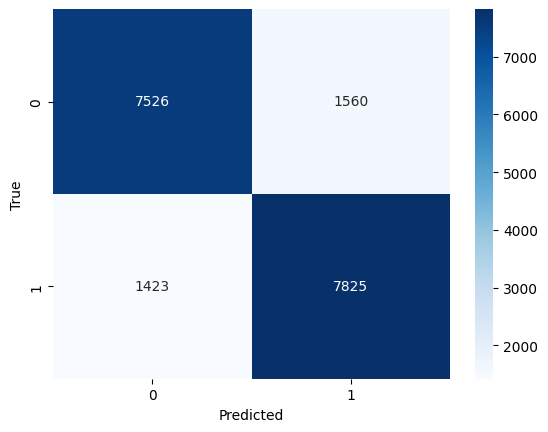

In [ ]:
best_knn = cv_knn_model.best_estimator_

y_pred_knn = best_knn.predict(x_test_norm)

score = f1_score(y_test, y_pred_knn, average='binary')

resultados_modelos['knn'] = score

print('F1-Score KNN: {}\n'.format(score))

metricas(y_pred_knn, y_test)

## SVM model

Como vimos en la teoría, sabemos que se obtienen mejores resultados usando Support Vector Machines al normalizar los datos. Esto es tener un conjunto de datos con desviación estándar unitaria para cada característica. Confirmamos está teoría con el ejemplo, para eso gereraremos una predicción para datos de train y test sin Cross Validation, una vez sin datos normalizados y otra con, y observamos la diferencia.

####Significado de parámetros


El parámetro C, según la página de scikit learn: "The C parameter trades off correct classification of training examples against maximization of the decision function’s margin". Es decir que es un regularizador, determina que tanto se ajustan los márgenes a los datos y cuánto se permiten las malas clasificaciones.

El parámetro gamma, según la bibliografía: "defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’".

degree, para el Kernel polinómico, define el grado del polinimio con el que serán modificadas las dimensiones de las observaciones para ser linealmente separables

coef0 para el Kernel polinómico define la ordenada al origen (corrimiento vertical) de la función, ayuda para ajustar datos en caso que no estén basados en el origen de coordenadas

###Datos normalizados vs NO normalizados

              precision    recall  f1-score   support

           0       0.59      0.71      0.65      9086
           1       0.65      0.52      0.57      9248

    accuracy                           0.61     18334
   macro avg       0.62      0.61      0.61     18334
weighted avg       0.62      0.61      0.61     18334



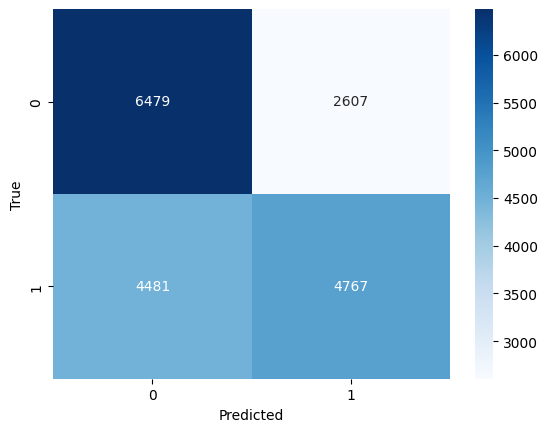

In [ ]:
svm = SVClassifier()

svm.fit(x_train, y_train)

y_pred=svm.predict(x_test)
metricas(y_pred,y_test)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      9086
           1       0.85      0.82      0.84      9248

    accuracy                           0.84     18334
   macro avg       0.84      0.84      0.84     18334
weighted avg       0.84      0.84      0.84     18334



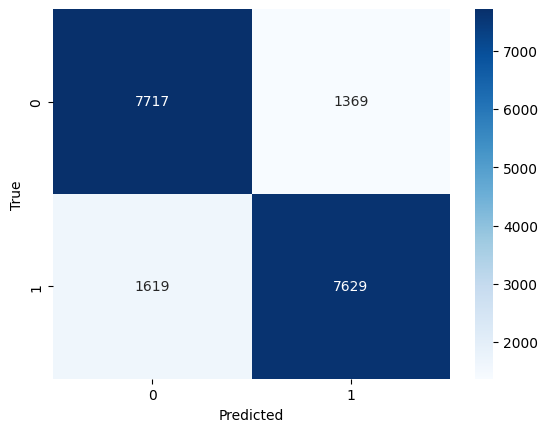

In [ ]:
svm_norm= SVClassifier()

svm_norm.fit(x_train_norm, y_train)

y_pred_norm_svm=svm_norm.predict(x_test_norm)
metricas(y_pred_norm_svm, y_test)

Observamos que sin haber modificado hiperparámetros ni haciendo un mayor ajuste de datos, mejoran significativamente las predicciones (según la métrica que nos compete F1) al estar estos normalizados. Si bien esto es muestra y no una demostración, al ver que desde la documentación advierte que el comportamiento es como describimos, para este modelo usaremos datos normalizados.

### SVM con Kernel radial (RBF - Radial Basis Function)

**Kernel RBF utilizando parametros por default**

Observamos que anteriormente cuando realizamos el análisis sobre los datos normalizados utilizamos *SVClassifier*, el cual utiliza el kernel 'rbf' por default, por lo tanto para esta etapa reutilizaremos el mismo modelo ya entrenado con las predicciones realizadas y simplemente imprimimos las diferentes metricas.

In [ ]:
rbf_svm_default = svm_norm

y_pred_svm_rbf_default = y_pred_norm_svm

score = f1_score(y_test, y_pred_svm_rbf_default, average='binary')

print('F1-Score SVM (kernel radial - default): {}\n'.format(score))

F1-Score SVM (kernel radial - default): 0.8362380795790858



**Kernel RBF modificando parametros**

Debido a la complejidad computacional que puede alcanzar dependiendo de los parametros *C* y *gamma*, la elección de estos fue tomada a partir del análisis de la documentación de scikit-learn, [RBF SVM parameters](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html), y de las clases practicas de la catedra.

In [ ]:
rbf_svm = SVClassifier(kernel='rbf', C=5.0, gamma=0.1)

rbf_svm.fit(x_train_norm, y_train) #Usamos el conjunto de train normalizado

y_pred_svm_rbf = rbf_svm.predict(x_test_norm) #Predecimos sobre el conjunto de test normalizado

score = f1_score(y_test, y_pred_svm_rbf, average='binary')

print('F1-Score SVM (kernel radial, C=5, gamma=0.1): {}\n'.format(score))

F1-Score SVM (kernel radial, C=5, gamma=0.1): 0.8440396812489837



In [ ]:
rbf_svm_2 = SVClassifier(kernel='rbf', C=10**8, gamma=10**-7)

rbf_svm_2.fit(x_train_norm, y_train) #Usamos el conjunto de train normalizado

y_pred_svm_rbf_2 = rbf_svm_2.predict(x_test_norm) #Predecimos sobre el conjunto de test normalizado

score = f1_score(y_test, y_pred_svm_rbf_2, average='binary')

print('F1-Score SVM (kernel radial, C=10^8, gamma=10^-7): {}\n'.format(score))

F1-Score SVM (kernel radial, C=10^8, gamma=10^-7): 0.795004972925185



In [ ]:
rbf_svm_3 = SVClassifier(kernel='rbf', C=100, gamma=0.001)

rbf_svm_3.fit(x_train_norm, y_train) #Usamos el conjunto de train normalizado

y_pred_svm_rbf_3 = rbf_svm_3.predict(x_test_norm) #Predecimos sobre el conjunto de test normalizado

score = f1_score(y_test, y_pred_svm_rbf_3, average='binary')

print('F1-Score SVM (kernel radial, C=100, gamma=0.001): {}\n'.format(score))

F1-Score SVM (kernel radial, C=100, gamma=0.001): 0.8204308777343104



**Conclusión SVM con kernel radial**

Luego de variar *C* y *gamma* con el kernel radial llegamos que el mejor modelo fue el *rbf_svm* con un f1-score de ~0.844. Procedemos a imprimir y analizar sus diferentes metricas.

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      9086
           1       0.85      0.84      0.84      9248

    accuracy                           0.84     18334
   macro avg       0.84      0.84      0.84     18334
weighted avg       0.84      0.84      0.84     18334



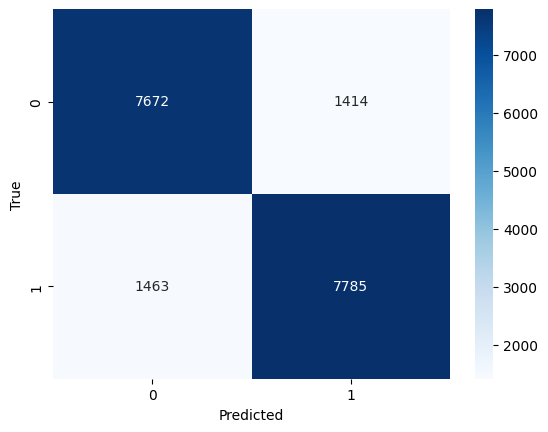

In [ ]:
score = f1_score(y_test, y_pred_svm_rbf, average='binary')

resultados_modelos['svm_rbf'] = score

metricas(y_pred_svm_rbf, y_test)

### SVM con Kernel polinómico

**Kernel polinómico utilizando hiperparametros por default**

In [ ]:
poly_svm_default = SVClassifier(kernel='poly')

poly_svm_default.fit(x_train_norm, y_train)

y_pred_svm_poly_default = poly_svm_default.predict(x_test_norm)

score = f1_score(y_test, y_pred_svm_poly_default, average='binary')

print('F1-Score SVM (kernel polinómico - default): {}\n'.format(score))

F1-Score SVM (kernel polinómico - default): 0.8290972830850131



**Kernel polinómico modificando hiperparametros**

In [ ]:
poly_svm = SVClassifier(kernel='poly', C=1.0, degree=3, gamma=0.09999999999999999, coef0=0.0)

poly_svm.fit(x_train_norm, y_train)

y_pred_svm_poly = poly_svm.predict(x_test_norm)

score = f1_score(y_test, y_pred_svm_poly, average='binary')

print('F1-Score SVM (kernel polinómico, C=1, degree=3, gamma= 0.09999999999999999, coef0=0): {}\n'.format(score))

F1-Score SVM (kernel polinómico, C=1, degree=3, gamma= 0.09999999999999999, coef0=0): 0.8454221165279429



In [ ]:
poly_svm_2 = SVClassifier(kernel='poly', C=1.0, degree=5, gamma=0.09999999999999999, coef0=0.0)

poly_svm_2.fit(x_train_norm, y_train)

y_pred_svm_poly_2 = poly_svm_2.predict(x_test_norm)

score = f1_score(y_test, y_pred_svm_poly_2, average='binary')

print('F1-Score SVM (kernel polinómico, C=1, degree=5, gamma= 0.09999999999999999, coef0=0): {}'.format(score))

F1-Score SVM (kernel polinómico, C=1, degree=5, gamma= 0.09999999999999999, coef0=0): 0.8319597559670341


In [ ]:
poly_svm_3 = SVClassifier(kernel='poly', C=1.0, degree=2, gamma=0.09999999999999999, coef0=10.0)

poly_svm_3.fit(x_train_norm, y_train)

y_pred_svm_poly_3 = poly_svm_3.predict(x_test_norm)

score = f1_score(y_test, y_pred_svm_poly_3, average='binary')

print('F1-Score SVM (kernel polinómico, C=1, degree=2, gamma= 0.09999999999999999, coef0=10): {}\n'.format(score))

F1-Score SVM (kernel polinómico, C=1, degree=2, gamma= 0.09999999999999999, coef0=10): 0.823168392788646



**Conclusión SVM con kernel polinómico**

Luego de variar los diferentes hiperparametros con el kernel polinómico llegamos a que el mejor modelo fue el *poly_svm* con un f1-score de ~0.845. Procedemos a imprimir y analizar sus diferentes metricas.

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      9086
           1       0.85      0.85      0.85      9248

    accuracy                           0.84     18334
   macro avg       0.84      0.84      0.84     18334
weighted avg       0.84      0.84      0.84     18334



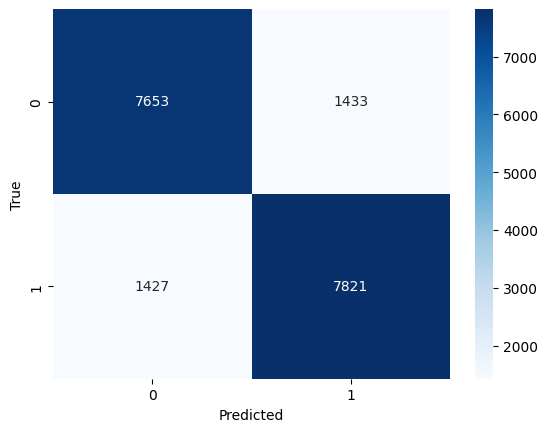

In [ ]:
score = f1_score(y_test, y_pred_svm_poly, average='binary')

resultados_modelos['svm_poly'] = score

metricas(y_pred_svm_poly, y_test)

##Random Forest

In [ ]:
params_rf = {
    'n_estimators': [200, 300, 400], #n de árboles
    'max_features': ['sqrt', 'log2'], #n de columnas a analizar para buscar el mejor split
    'max_depth': [None] + list(np.arange(10, 110, 10)), #Profundidad máxima de cada árbol
    'min_samples_split': [5, 8, 10], #minimo de casos para que el nodo se divida
    'min_samples_leaf': [2, 5, 10], #minimo de casos para que el nodo sea hoja
    'bootstrap': [True, False] #True -> Bagging
}

rf = RandomForestClassifier(random_state=42)

# Quisimos hacer con GridSearchCV pero toma demasiado tiempo
random_search_rf = RandomizedSearchCV(rf, params_rf, scoring=make_scorer(f1_score), cv=5, n_iter=5)

random_search_rf.fit(x_train_norm, y_train)

print(random_search_rf.best_params_)

{'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}


F1-Score RF: 0.8788570186875271

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      9086
           1       0.88      0.87      0.88      9248

    accuracy                           0.88     18334
   macro avg       0.88      0.88      0.88     18334
weighted avg       0.88      0.88      0.88     18334



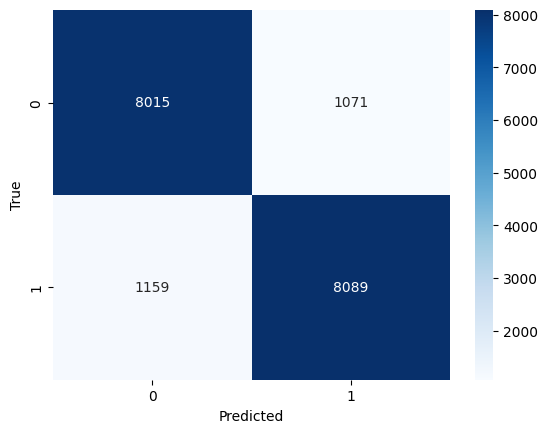

In [ ]:
best_rf = random_search_rf.best_estimator_

y_pred_rf = best_rf.predict(x_test_norm)

score = f1_score(y_test, y_pred_rf, average='binary')

resultados_modelos['rf'] = score

print('F1-Score RF: {}\n'.format(score))

metricas(y_pred_rf, y_test)

##XGBoost

XGBoost (eXtreme Gradient Boosting) es un método de aprendizaje automático supervisado para clasificación y regresión basado en el Boosting, en este caso usado para clasificación. Esto es una forma de aprendizaje de los modelos basada en generar predicciones y asignar un mayor peso a aquellas mal clasificadas, asi iterativamente hasta un límite determinado por los hiperparámetros.

In [ ]:
# params_xgboost = {
#     'max_depth': range(3, 10),
#     # "Cuánto más va a aprender el modelo en cada paso"
#     'learning_rate': np.linspace(0.01, 0.3, 30),
#     'n_estimators': range(100, 1000, 100),
#     # Fracción de casos usado para cada árbol de entrenamiento
#     'subsample': np.linspace(0.5, 1.0, 6),
#     # Fracción de columnas usadas para cada árbol de entrenamiento
#     'colsample_bytree': np.linspace(0.5, 1.0, 6),
#     # Determina cuánto porcentaje deben aumentar los aciertos
#     # para que un split sea considerado beneficioso
#     'gamma': [0, 0.1, 0.2, 0.3, 0.4],

#     # Ambas son para penalizar y ponderar la ganancia de inforamción
#     # de las variables, lo hacen de distinto modo y logran distintos
#     # resultados
#     'reg_alpha': [0, 1, 2, 3, 4],
#     'reg_lambda': [0, 1, 2, 3, 4],
# }

# #Usamos XGBoost con árboles como estimadores
# xgb = xgb.XGBClassifier(booster='gbtree', random_state=42)

# random_search_xgb = RandomizedSearchCV(xgb, param_distributions=params_xgboost, n_iter=10, cv=5, n_jobs=-1, random_state=42)

# random_search_xgb.fit(x_train, y_train)

In [ ]:
# best_xgb = random_search_xgb.best_estimator_

# y_pred_xgb = best_xgb.predict(x_test)

# score = f1_score(y_test, y_pred_xgb, average='binary')

# resultados_modelos['xgb'] = score

# print('F1-Score XGB: {}'.format(score))

# metricas(y_pred_xgb, y_test)

F1-Score XGB: 0.8778519156263451

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      9086
           1       0.87      0.88      0.88      9248

    accuracy                           0.88     18334
   macro avg       0.88      0.88      0.88     18334
weighted avg       0.88      0.88      0.88     18334



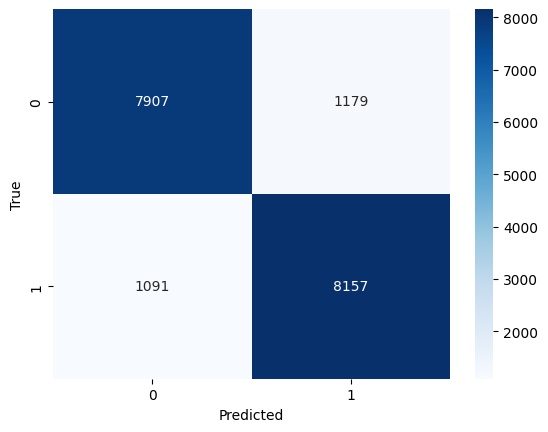

In [ ]:
# Parametros obtenidos tras iterar y probar

parametros_optimos = {
    'subsample': 1.0,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'n_estimators': 800,
    'max_depth': 9,
    'learning_rate': 0.06999999999999999,
    'gamma': 0.1,
    'colsample_bytree': 0.6
}

xgb_optimo = xgb.XGBClassifier(booster='gbtree', random_state=42, **parametros_optimos)

xgb_optimo.fit(x_train_norm, y_train)

y_pred_xgb = xgb_optimo.predict(x_test_norm)

score = f1_score(y_test, y_pred_xgb, average='binary')

resultados_modelos['xgb'] = score

print('F1-Score XGB: {}\n'.format(score))

metricas(y_pred_xgb, y_test)

##Ensambles de modelos

En esta sección utilizaremos los modelos ya entrenados para crear un ensamble de modelos, esto es, que cada uno de ellos genere una predicción para los datos de entrada y luego, mediante Stacking o Voting, decidir cuál sera el output final de la clasificación

In [ ]:
# # KNN
# best_knn = joblib.load('/content/drive/MyDrive/datasetsTP/modelos/best_knn.joblib')

# # SVM Radial
# rbf_svm = joblib.load(/content/drive/MyDrive/datasetsTP/modelos/rbf_svm.joblib')

# # SVM Polinomial
# poly_svm = joblib.load('/content/drive/MyDrive/datasetsTP/modelos/poly_svm.joblib')

# # Random Forest
# best_rf = joblib.load(/content/drive/MyDrive/datasetsTP/modelos/best_rf.joblib')

# # XGBoost
# xgb_optimo = joblib.load('/content/drive/MyDrive/datasetsTP/modelos/best_xgb.joblib')

###Voting

Voting es una técnica de dicisión del output final que consta en tomar la predicción mayoritaria, es decir como un sistema de votación tal como indica el nombre. Como hiperparámetros se puede decidir si ponderar la importancia de cada uno de los votos (voting = "soft").

F1-Score Voting: 0.8657301535445933

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      9086
           1       0.87      0.86      0.87      9248

    accuracy                           0.87     18334
   macro avg       0.87      0.87      0.87     18334
weighted avg       0.87      0.87      0.87     18334



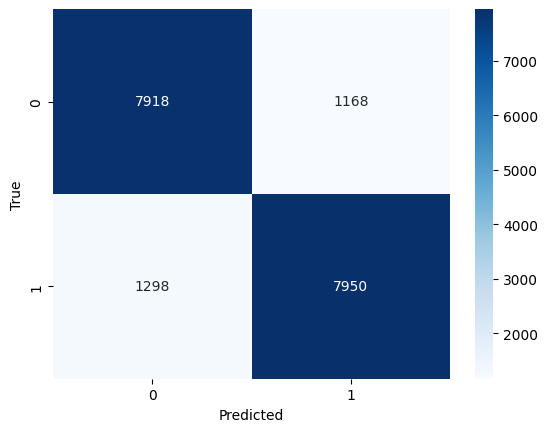

In [ ]:
# Usamos todos los estimadores entrenados en esta notebook
estimadores = [
    ('rf', best_rf),
    ('rbf_svm', rbf_svm),
    ('poly_svm', poly_svm),
    ('knn', best_knn),
    ('xgb', xgb_optimo)
]

voting_clf = VotingClassifier(estimators=estimadores, voting='hard')

voting_clf.fit(x_train_norm, y_train)

y_pred_voting = voting_clf.predict(x_test_norm)

score = f1_score(y_test, y_pred_voting, average='binary')

resultados_modelos['voting'] = score

print('F1-Score Voting: {}\n'.format(score))

metricas(y_pred_voting, y_test)

###Stacking

Stacking, a diferencia de Voting, no determina el resultado final según el voto mayoritario, sino que la decisión final es también un modelo que, al ser nuestra problema de clasificación, recibirá una serie de booleanos que tomará como información de entrenamiento y decidirá el output final a partir de lo aprendido.

F1-Score Stacking: 0.8788288044946247
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      9086
           1       0.88      0.88      0.88      9248

    accuracy                           0.88     18334
   macro avg       0.88      0.88      0.88     18334
weighted avg       0.88      0.88      0.88     18334



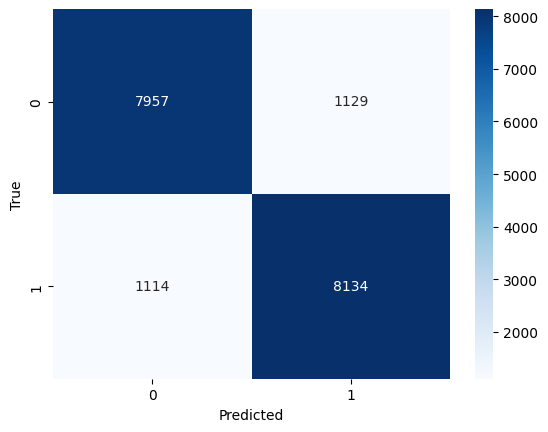

In [ ]:
#Modelo que usamos como estimador final
meta_model = LogisticRegressionCV(max_iter=2000)

stacking_model = StackingClassifier(estimators=estimadores,
                                    final_estimator=meta_model,
                                    passthrough=True,
                                    cv=2,
                                    verbose=2)

stacking_model.fit(x_train_norm, y_train)
y_pred_st = stacking_model.predict(x_test_norm)

score = f1_score(y_test, y_pred_st, average='binary')

resultados_modelos['stacking'] = score

print('F1-Score Stacking: {}'.format(score))

metricas(y_pred_st, y_test)

##Comparación final

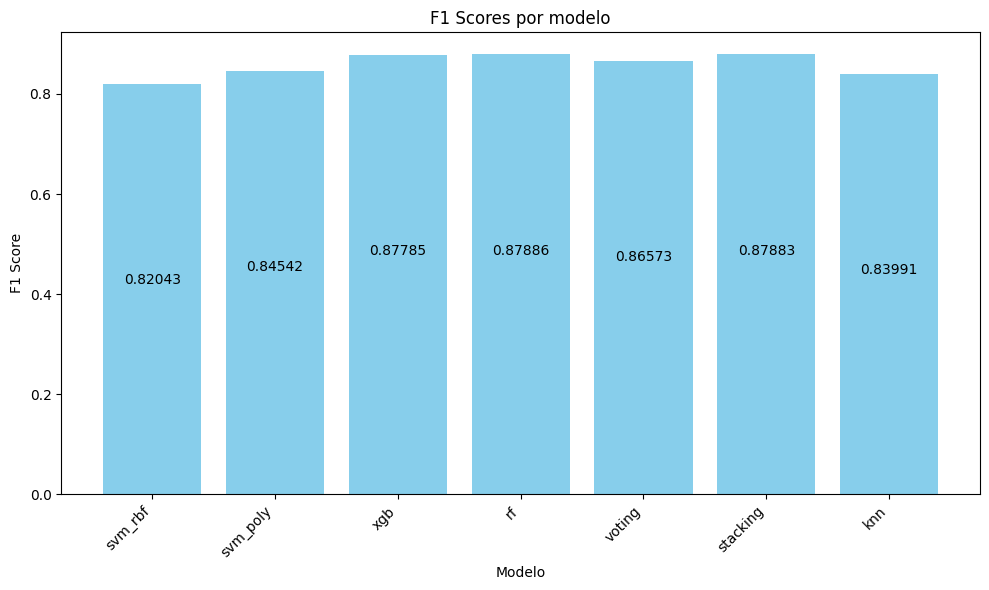

In [ ]:
nombres_modelos = list(resultados_modelos.keys())
f1_scores = list(resultados_modelos.values())

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]-0.4, round(y[i], 5), ha = 'center')

plt.figure(figsize=(10, 6))
plt.bar(nombres_modelos, f1_scores, color='skyblue')
plt.title('F1 Scores por modelo')
plt.xlabel('Modelo')
plt.ylabel('F1 Score')

addlabels(nombres_modelos, f1_scores)

plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

## Exportación de modelos

In [ ]:
# Descomentar lineas de abajo en caso de querer exportar un modelo en un archivo joblib

# # KNN
# joblib.dump(best_knn, '/content/drive/MyDrive/datasetsTP/modelos/best_knn.joblib')

# # SVM Radial
# joblib.dump(rbf_svm, '/content/drive/MyDrive/datasetsTP/modelos/rbf_svm.joblib')

# # SVM Polinomial
# joblib.dump(poly_svm, '/content/drive/MyDrive/datasetsTP/modelos/poly_svm.joblib')

# # Random Forest
# joblib.dump(best_rf, '/content/drive/MyDrive/datasetsTP/modelos/best_rf.joblib')

# # XGBoost
# joblib.dump(xgb_optimo, '/content/drive/MyDrive/datasetsTP/modelos/xgb_optimo.joblib')

# # Voting
# joblib.dump(voting_clf, '/content/drive/MyDrive/datasetsTP/modelos/voting_clf.joblib')

# # Stacking
# joblib.dump(stacking_model, '/content/drive/MyDrive/datasetsTP/modelos/stacking_model.joblib')

##Submits

### Generación de predicciónes para submits


In [ ]:
# Descomentar lineas de abajo en caso de querer generar el submit para los modelos

# # KNN
# df_submit_knn = generar_df_submit_norm(best_knn)

# # SVM Radial
# df_submit_rbf_svm = generar_df_submit_norm(rbf_svm)

# # SVM Polinomico
# df_submit_poly_svm = generar_df_submit_norm(poly_svm)

# # Random Forest
# df_submit_rf = generar_df_submit_norm(best_rf)

# # XGBoost
# df_submit_xgb = generar_df_submit_norm(xgb_optimo)

# # Voting
# df_submit_voting = generar_df_submit_norm(voting_clf)

# # Stacking
# df_submit_stacking = generar_df_submit_norm(stacking_model)

###Subida de submits al drive

In [ ]:
# Descomentar lineas de abajo en caso de querer subir el submit para los modelos al drive

# # KNN
# df_submit_knn.to_csv('/content/drive/MyDrive/datasetsTP/submits/submit_knn.csv', index = False)

# # SVM Radial
# df_submit_rbf_svm.to_csv('/content/drive/MyDrive/datasetsTP/submits/submit_rbf_svm.csv', index = False)

# # SVM Polinomico
# df_submit_poly_svm.to_csv('/content/drive/MyDrive/datasetsTP/submits/submit_poly_svm.csv', index = False)

# # Random Forest
# df_submit_rf.to_csv('/content/drive/MyDrive/datasetsTP/submits/submit_rf.csv', index = False)

# # XGBoost
# df_submit_xgb.to_csv('/content/drive/MyDrive/datasetsTP/submits/submit_xgb.csv', index = False)

# # Voting
# df_submit_voting.to_csv('/content/drive/MyDrive/datasetsTP/submits/submit_voting.csv', index = False)

# # Stacking
# df_submit_stacking.to_csv('/content/drive/MyDrive/datasetsTP/submits/submit_stacking.csv', index = False)